# Курсовой проект 
# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn 
Грибанов Дмитрий

**Содержание**
* [1. Подготовка](#prepare)
* [2. Загрузка данных](#load_data)
* [3. EDA](#eda)
* [4. Обработка выбросов и пропусков](#nan_outlier)
* [5. Построение новых признаков](#new_features)
* [6. Отбор признаков](#feature_selection)
* [7. Разбиение на train и test](#split)
* [8. Построение модели](#modeling)
* [9. Прогнозирование на тестовом датасете](#prediction)

### 1. Подготовка <a class='anchor' id='prepare'>

#### Загрузка библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from datetime import datetime

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'png'

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(16,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к файлам**

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### 2. Загрузка данных <a class='anchor' id='load_data'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

# Уменьшение памяти занимаемой датафреймом
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [8]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [10]:
print(f'Учебный датасет: {train_df.shape}')
print(f'Тестовый датасет: {test_df.shape}')

Учебный датасет: (10000, 20)
Тестовый датасет: (5000, 19)


**Приведение типов**

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
# train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### 3. EDA <a class='anchor' id='eda'>

**Целевая переменная**

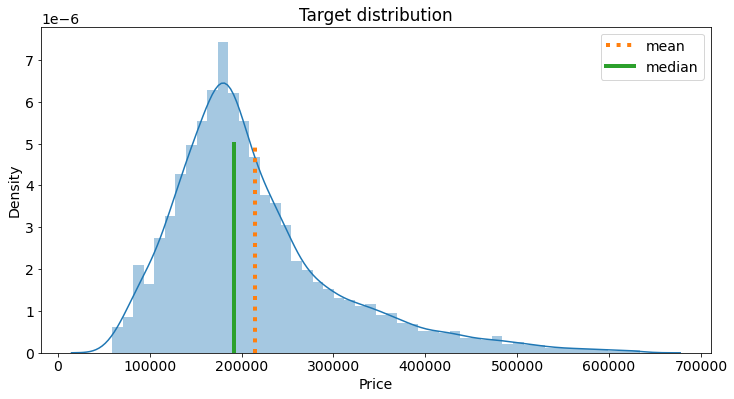

In [12]:
plt.figure(figsize = (12, 6))

target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

sns.distplot(train_df['Price'], bins=50)
y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)

plt.title('Target distribution')
plt.legend()

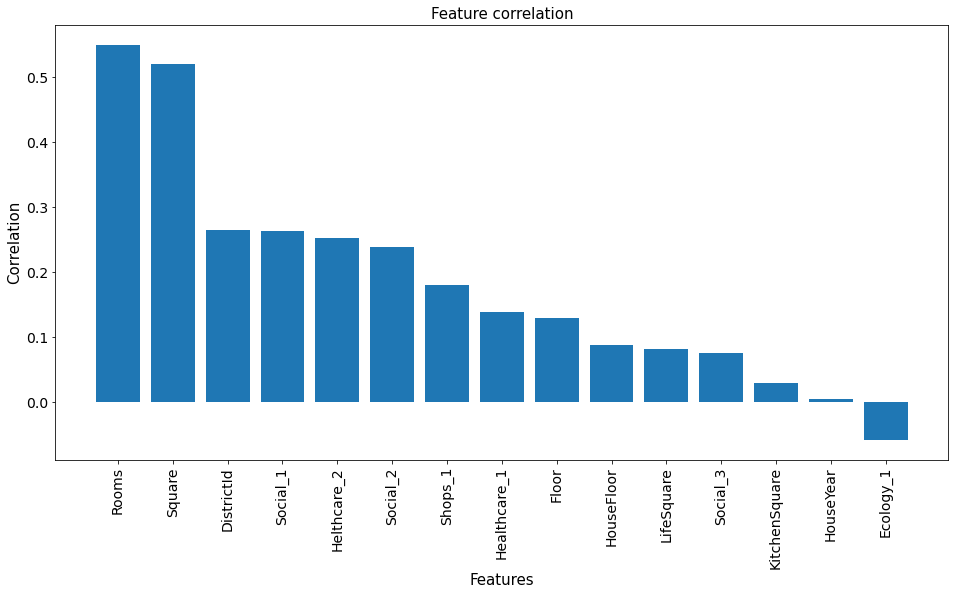

In [13]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

**Количественные переменные**

In [14]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**Дискретные переменные**

In [15]:
train_df.describe(include=['object', 'category'])

,Id,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000,10000
unique,10000,2,2,2
top,5289,B,B,B
freq,1,9903,9725,9175


In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 4. Обработка выбросов и пропусков<a class='anchor' id='nan_outlier'>

**Square and LifeSquare**

Заменим значения если 'Square' < 'LifeSquare'

In [19]:
train_df[(train_df['Square'] < train_df['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,73.314972,74.131264,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.375000
64,3992,1,3.0,87.200623,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.375000
77,11771,45,1.0,38.467278,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.531250
100,13343,74,2.0,79.937668,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.750000
111,13875,20,1.0,28.438793,32.514023,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056786,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.562500
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.382812
9979,2201,6,1.0,40.043236,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.078125
9987,11665,1,2.0,62.690056,64.602936,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.187500


Заменим значения LifeSquare > Square. Создадим признак LifeSquare_Square_outlier.

In [20]:
train_df['LifeSquare_Square_outlier'] = 0
train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'LifeSquare_Square_outlier'] = 1

In [21]:
train_df['Square'], train_df['LifeSquare'] = \
        np.where(train_df['Square'] < train_df['LifeSquare'], \
                 (train_df['LifeSquare'],train_df['Square']), (train_df['Square'],train_df['LifeSquare']))

In [22]:
train_df[(train_df['Square'] < train_df['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier


**Rooms**

In [23]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Создадим Rooms_outlier

In [24]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df[train_df['Rooms_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,74,19083,2,NaN,5,15,B,317265.312500,0,1
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,43,8429,3,NaN,3,9,B,158998.109375,0,1
2728,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,...,25,5648,1,30.0,2,4,B,172329.265625,0,1
3780,7317,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,98129.976562,0,1
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,30,6207,1,1183.0,1,0,B,217009.343750,0,1
6088,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,...,1,264,0,NaN,0,1,B,78364.617188,0,1
6401,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,219281.921875,0,1
7644,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,9,1892,0,NaN,0,1,B,302211.250000,0,1
7929,456,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,212864.796875,0,1
8794,14003,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,...,66,10573,1,1322.0,3,8,B,229661.968750,0,1


.

Идея: заполнять неадекватные значения количества комнат значениями (1,2,3,4,5) в зависимости от общей площади.

Посмотрим на медианы по количеству комнат, чтобы определить диапазоны площадей для каждого вида квартиры.

In [25]:
train_df.groupby('Rooms').median()

,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_Square_outlier,Rooms_outlier
Rooms,,,,,,,,,,,,,,,,,
0.0,27.0,65.487473,85.125473,0.0,4.5,1.5,1979.5,0.169389,9.0,1892.0,0.0,861.5,0.0,0.5,214937.062500,0,1
1.0,30.0,40.504280,21.662834,6.0,8.0,14.0,1977.0,0.075779,23.0,5148.0,1.0,830.0,1.0,3.0,154979.500000,0,0
2.0,35.0,55.900612,32.546825,6.0,7.0,12.0,1977.0,0.075779,25.0,5285.0,2.0,990.0,1.0,3.0,200320.750000,0,0
3.0,44.0,77.469849,46.958214,7.0,8.0,14.0,1977.0,0.072158,25.0,5569.0,2.0,830.0,1.0,4.0,268723.156250,0,0
4.0,58.5,98.689003,64.946548,9.0,6.0,10.0,1985.0,0.072158,29.5,6145.0,4.0,1046.0,1.0,5.0,377524.250000,0,0
5.0,57.5,116.084862,80.458908,9.0,5.5,6.5,1977.0,0.081478,24.0,4916.5,3.0,1863.5,1.0,5.0,455355.625000,0,0
6.0,99.0,59.414333,38.702244,6.0,7.0,9.0,1969.0,0.033494,66.0,10573.0,1.0,1322.0,3.0,8.0,229661.968750,0,1
10.0,33.0,59.964119,37.321877,10.0,12.5,12.0,1998.0,0.126165,49.5,12365.5,1.5,30.0,3.5,9.5,244797.281250,0,1
19.0,1.0,42.006046,21.779287,7.0,17.0,17.0,2014.0,0.007122,1.0,264.0,0.0,NaN,0.0,1.0,78364.617188,0,1


In [26]:
def rooms_filling(flat_square):
    """Получает общую площадь квартиры, отдает предполагаемое количество комнат."""
    
    if 0 < abs(flat_square) <= 42:
        return 1
    elif 42 < abs(flat_square) <= 60:
        return 2
    elif 60 < abs(flat_square) <= 85:
        return 3
    elif 85 < abs(flat_square) <= 105:
        return 4
    else:
        return 5
    
#     if 0 < abs(flat_square) <= 42:
#         return 1
#     elif 42 < abs(flat_square) <= 65:
#         return 2
#     elif 65 < abs(flat_square) <= 85:
#         return 3
#     elif 85 < abs(flat_square) <= 105:
#         return 4
#     else:
#         return 5
    
    
    # Поиграться со значениями !!!!!!!!!!!!!!

Заменим 0 или неадеквартное количество комнат на примерное количество комнат, которое бывает у квартир с такой же общей площадью.

In [27]:
train_df.loc[train_df['Rooms_outlier'] == 1, 'Rooms'] = \
                                    train_df.loc[train_df['Rooms_outlier'] == 1, 'Square'].apply(rooms_filling)

In [28]:
# посмотрим результат замены
train_df[train_df['Rooms_outlier'] == 1]['Rooms']

2004    2.0
2194    1.0
2728    3.0
3780    1.0
5894    2.0
6088    2.0
6401    4.0
7644    5.0
7929    3.0
8794    2.0
9767    5.0
9869    1.0
Name: Rooms, dtype: float32

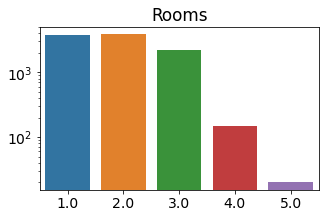

In [29]:
counts = train_df['Rooms'].value_counts()
    
plt.figure(figsize=(5,3))    
plt.title('Rooms')
sns.barplot(counts.index, counts.values, log=True)
    
plt.show()

**Square**

(array([9.000e+00, 8.000e+00, 7.900e+01, 1.702e+03, 2.849e+03, 1.694e+03,
        1.634e+03, 9.040e+02, 6.860e+02, 1.670e+02, 1.260e+02, 4.500e+01,
        4.100e+01, 2.200e+01, 4.000e+00, 3.000e+00, 9.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
        440., 450., 460., 470., 480., 490., 500.], dtype=float32),
 <BarContaine

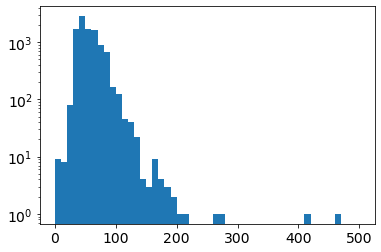

In [30]:
plt.hist(train_df['Square'], bins=50, range=(0, 500), log=True)

Посмотрим Square > 300

In [31]:
train_df[train_df['Square'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier
726,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,...,25,5648,1,30.0,2,4,B,187717.250000,0,0
5183,15886,85,3.0,461.463623,78.059334,10.0,12,16.0,1998,0.037178,...,52,11217,1,2300.0,1,7,B,394253.312500,1,0
7010,2307,102,1.0,410.639740,409.425171,10.0,4,4.0,2016,0.238617,...,26,3889,6,705.0,3,6,B,90470.429688,1,0
8000,16550,27,3.0,7480.592285,81.694420,1.0,9,17.0,2016,0.017647,...,2,469,0,NaN,0,0,B,217357.500000,1,0
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,...,22,6398,141,1046.0,3,23,B,133529.687500,0,0


Большее количество значений - это площади до 200 кв. Несколько ячеек - площади от 200 до 300 кв. Больше 300 надо обрабатывать.

.

Посмотрим Square < 20

In [32]:
train_df[train_df['Square'] < 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier
161,6782,45,1.0,5.257278,2.954309,1.0,3,1.0,1977,0.195781,...,23,5212,6,NaN,3,2,B,438005.187500,1,0
328,4504,27,3.0,5.610772,4.390331,1.0,8,19.0,2016,0.211401,...,9,1892,0,NaN,0,1,B,161379.062500,1,0
1401,9487,5,1.0,5.549458,5.129221,1.0,1,1.0,1977,0.150818,...,16,3433,4,2643.0,4,5,B,369472.406250,1,0
3686,15877,57,3.0,16.698570,16.547241,8.0,5,5.0,1962,0.133215,...,49,11395,3,1406.0,3,4,A,77835.187500,1,0
4496,15744,34,1.0,2.642219,1.988943,1.0,21,4.0,1977,0.069753,...,53,13670,4,NaN,1,11,B,458378.781250,1,0
4800,7657,38,1.0,4.618547,4.502784,1.0,28,1.0,1977,0.060753,...,15,2787,2,520.0,0,7,B,483283.500000,1,0
5009,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,...,4,915,0,NaN,0,0,B,107604.265625,0,0
5870,6927,21,1.0,16.117155,8.822989,0.0,2,5.0,1965,0.194489,...,47,8004,3,125.0,3,5,B,79913.265625,0,0
6632,13685,0,1.0,17.498543,13.446544,0.0,7,5.0,1961,0.319809,...,25,4756,16,2857.0,5,8,B,88871.750000,0,0
7209,14236,0,1.0,19.927423,15.541536,0.0,2,5.0,1962,0.319809,...,25,4756,16,2857.0,5,8,B,102395.789062,0,0


Заменим Square < 20 и Square > 300 медианами Square от количества комнат (Rooms).

In [33]:
# med_square_by_rooms = train_df.groupby(['Rooms'], as_index=False).agg({'Square':'median'})\
#                             .rename(columns={'Price':'MedSquareByRooms'})
# med_square_by_rooms

In [34]:
med_square_by_rooms = train_df.groupby(['Rooms'])['Square'].agg('median').to_dict()
med_square_by_rooms

{1.0: 40.502037048339844,
 2.0: 55.900611877441406,
 3.0: 77.4698486328125,
 4.0: 98.68670654296875,
 5.0: 118.36396026611328}

In [35]:
med_square_cond = (train_df['Square'] < 20) | (train_df['Square'] > 300)

train_df.loc[med_square_cond, 'Square'] = train_df.loc[med_square_cond]['Rooms'].map(med_square_by_rooms)

In [36]:
train_df.loc[(train_df['Square'] < 20) | (train_df['Square'] > 300), 'Square']

Series([], Name: Square, dtype: float32)

**KitchenSquare**

In [37]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [38]:
train_df['KitchenSquare'].quantile(0.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

Площадь кухни менее или равна 13 у 97,5% квартир.

Посмотрим медиану для площади кухни каждого вида квартир (1 комн, 2 комн и тд)

In [39]:
med_kitchenSquare_by_rooms = train_df.groupby(['Rooms'])['KitchenSquare'].agg('median').to_dict()
med_kitchenSquare_by_rooms

{1.0: 6.0, 2.0: 6.0, 3.0: 7.0, 4.0: 9.0, 5.0: 8.5}

In [40]:
min_kitchen_square = 3  # ввел минимальное значение площади кухни, чтобы им можно было варьировать.

Заменим площади кухни больше квантиля 0,975 и меньше 3 на медианы по площадям кухонь от количества комнат.

In [41]:
med_kitchenSquare_cond = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) | \
               (train_df['KitchenSquare'] < min_kitchen_square)
        
train_df.loc[med_kitchenSquare_cond, 'KitchenSquare'] = \
             train_df.loc[med_kitchenSquare_cond]['Rooms'].map(med_kitchenSquare_by_rooms)

In [42]:
train_df['KitchenSquare'].value_counts()

6.0     3706
8.0     1306
7.0     1247
5.0     1169
10.0    1075
9.0      878
12.0     249
11.0     233
13.0      67
4.0       39
3.0       22
8.5        9
Name: KitchenSquare, dtype: int64

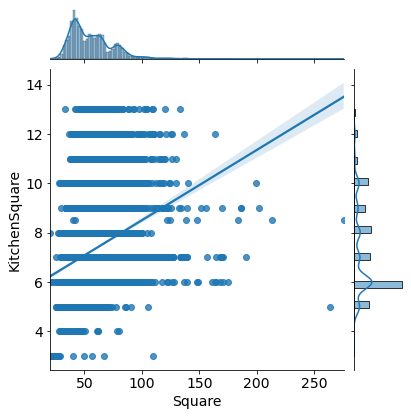

In [43]:
grid = sns.jointplot(train_df['Square'], train_df['KitchenSquare'], kind='reg')

**LifeSquare**

(array([2.260e+02, 2.312e+03, 2.534e+03, 1.745e+03, 5.570e+02, 2.530e+02,
        1.640e+02, 4.900e+01, 2.000e+01, 1.200e+01, 4.000e+00, 0.000e+00,
        4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([3.70619416e-01, 1.31264715e+01, 2.58823223e+01, 3.86381760e+01,
        5.13940277e+01, 6.41498795e+01, 7.69057312e+01, 8.96615829e+01,
        1.02417435e+02, 1.15173286e+02, 1.27929138e+02, 1.40684982e+02,
        1.53440842e+02, 1.66196686e+02, 1.78952545e+02, 1.91708389e+02,
        2.04464249e+02, 2.17220093e+02, 2.29975952e+02, 2.42731796e+02,
        2.554876

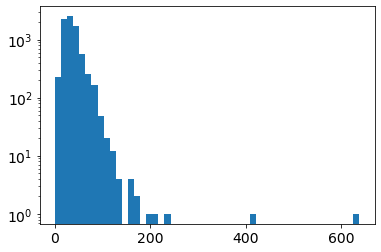

In [44]:
plt.hist(train_df['LifeSquare'], bins=50, log=True)

В гистограмму не вошли данные с NaN, большее количество значений - это жилые площади до 150 кв. Несколько ячеек - площади от 150 до 300 кв. И неадекват - 3 ячейки, площадь свыше 7к, 420 и 460.
Также посмотрим на площади меньше 15

.

In [45]:
train_df.loc[(train_df['LifeSquare'] > 150) | (train_df['LifeSquare'] < 15)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier
26,8553,88,3.0,83.262527,4.769175,7.0,13,1.0,1977,0.127376,...,43,8429,3,NaN,3,9,B,410883.906250,0,0
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,...,5,1564,0,540.0,0,0,B,174742.000000,0,0
161,6782,45,1.0,40.502037,2.954309,6.0,3,1.0,1977,0.195781,...,23,5212,6,NaN,3,2,B,438005.187500,1,0
212,1182,27,1.0,38.936985,3.064320,6.0,18,19.0,2017,0.211401,...,9,1892,0,NaN,0,1,B,93560.789062,0,0
227,3746,62,1.0,46.722042,1.944446,6.0,11,12.0,2018,0.072158,...,2,629,1,NaN,0,0,A,133721.125000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,13523,23,1.0,52.787090,5.600609,6.0,7,1.0,2015,0.014073,...,2,475,0,NaN,0,0,B,104160.492188,0,0
9915,8998,20,1.0,30.082090,12.125029,7.0,9,9.0,1976,0.019509,...,37,7687,11,176.0,5,5,B,186537.390625,0,0
9938,2913,34,4.0,94.888596,2.637095,9.0,4,1.0,2018,0.069753,...,53,13670,4,NaN,1,11,B,346949.500000,0,0
9982,10268,27,1.0,36.112392,1.855415,6.0,9,16.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,94881.695312,0,0


In [46]:
train_df.loc[train_df['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.875000,0,0
3,2352,1,1.0,40.409908,NaN,6.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.000000,0,0
18,4581,1,1.0,47.582481,NaN,6.0,16,16.0,1977,0.007122,...,1,264,0,NaN,0,1,B,128803.593750,0,0
20,8768,63,1.0,50.974892,NaN,6.0,7,16.0,2018,0.238617,...,26,3889,6,705.0,3,6,B,260328.406250,0,0
24,4717,27,1.0,44.203945,NaN,6.0,2,0.0,1977,0.072158,...,2,629,1,NaN,0,0,A,135466.562500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573132,NaN,6.0,18,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,154366.031250,0,0
9978,4851,1,1.0,39.314342,NaN,6.0,13,17.0,1977,0.007122,...,1,264,0,NaN,0,1,B,137782.937500,0,0
9981,6753,62,2.0,73.092690,NaN,6.0,4,16.0,2017,0.072158,...,2,629,1,NaN,0,0,A,159077.203125,0,0
9983,647,1,2.0,63.324024,NaN,6.0,4,17.0,1977,0.007122,...,1,264,0,NaN,0,1,B,183809.328125,0,0


Создадим признак LifeSquare_nan

In [47]:
train_df['LifeSquare_nan'] = 0
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
train_df[train_df['LifeSquare_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier,LifeSquare_nan
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.875000,0,0,1
3,2352,1,1.0,40.409908,NaN,6.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.000000,0,0,1
18,4581,1,1.0,47.582481,NaN,6.0,16,16.0,1977,0.007122,...,264,0,NaN,0,1,B,128803.593750,0,0,1
20,8768,63,1.0,50.974892,NaN,6.0,7,16.0,2018,0.238617,...,3889,6,705.0,3,6,B,260328.406250,0,0,1
24,4717,27,1.0,44.203945,NaN,6.0,2,0.0,1977,0.072158,...,629,1,NaN,0,0,A,135466.562500,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573132,NaN,6.0,18,17.0,1977,0.243205,...,1564,0,540.0,0,0,B,154366.031250,0,0,1
9978,4851,1,1.0,39.314342,NaN,6.0,13,17.0,1977,0.007122,...,264,0,NaN,0,1,B,137782.937500,0,0,1
9981,6753,62,2.0,73.092690,NaN,6.0,4,16.0,2017,0.072158,...,629,1,NaN,0,0,A,159077.203125,0,0,1
9983,647,1,2.0,63.324024,NaN,6.0,4,17.0,1977,0.007122,...,264,0,NaN,0,1,B,183809.328125,0,0,1


.

Заполним пропуски и >150 и <15 'LifeSquare' = 'Square' - 'KitchenSquare' - 10% * 'Square'

In [48]:
lifeSquare_cond = (train_df['LifeSquare'].isna()) | (train_df['LifeSquare'] > 150) | (train_df['LifeSquare'] < 15)

train_df.loc[lifeSquare_cond, 'LifeSquare'] = train_df.loc[lifeSquare_cond, 'Square'] - \
                    train_df.loc[lifeSquare_cond, 'KitchenSquare'] - (train_df.loc[lifeSquare_cond, 'Square'] * 0.1)

In [49]:
train_df.isna().sum()

Id                              0
DistrictId                      0
Rooms                           0
Square                          0
LifeSquare                      0
KitchenSquare                   0
Floor                           0
HouseFloor                      0
HouseYear                       0
Ecology_1                       0
Ecology_2                       0
Ecology_3                       0
Social_1                        0
Social_2                        0
Social_3                        0
Healthcare_1                 4798
Helthcare_2                     0
Shops_1                         0
Shops_2                         0
Price                           0
LifeSquare_Square_outlier       0
Rooms_outlier                   0
LifeSquare_nan                  0
dtype: int64

**HouseFloor, Floor**

In [50]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [51]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [52]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Идея: Заменить значения, если Floor > HouseFloor.

In [53]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [54]:
train_df['Floor'], train_df['HouseFloor'] = \
        np.where(train_df['HouseFloor_outlier'] == 1, \
                 (train_df['HouseFloor'],train_df['Floor']), (train_df['Floor'],train_df['HouseFloor']))

Заменим 0 значения Floor на случайное из диапазона [1, HouseFloor]

In [55]:
floor_zeros = train_df.loc[train_df['Floor'] == 0].index
floor_zeros

Int64Index([  24,  152,  159,  186,  229,  233,  256,  260,  303,  306,
            ...
            9762, 9766, 9820, 9824, 9869, 9889, 9931, 9940, 9950, 9996],
           dtype='int64', length=269)

In [56]:
train_df.loc[floor_zeros, 'Floor'] = train_df.loc[floor_zeros, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [57]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_Square_outlier,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.889100,56.357693,39.347050,7.263050,7.836200,13.435700,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500,0.048200,0.001200,0.211300,0.182500
std,43.587592,0.812798,19.202488,17.525249,1.878155,5.203807,6.094054,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438,0.214199,0.034622,0.408251,0.386275
min,0.000000,1.000000,20.036232,12.546085,3.000000,1.000000,1.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.872912,26.862233,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906,0.000000,0.000000,0.000000,0.000000
50%,36.000000,2.000000,52.659376,34.750885,7.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438,0.000000,0.000000,0.000000,0.000000
75%,75.000000,2.000000,66.004633,48.088801,9.000000,11.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938,0.000000,0.000000,0.000000,0.000000
max,209.000000,5.000000,275.645294,239.580765,13.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,1.000000


**HouseYear**

In [58]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [59]:
current_year = datetime.now().year
        
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

**Healthcare_1**

In [60]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [61]:
train_df.describe(include='all')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
unique,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,5289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9175,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,50.400800,1.889100,56.357693,39.347050,7.263050,7.836200,13.435700,1984.872600,0.118858,...,8.039200,1.319500,4.231300,NaN,214138.937500,0.048200,0.001200,0.211300,0.182500,0.000200
std,NaN,43.587592,0.812798,19.202488,17.525249,1.878155,5.203807,6.094054,18.416734,0.119025,...,23.831875,1.493601,4.806341,NaN,92872.273438,0.214199,0.034622,0.408251,0.386275,0.014141
min,NaN,0.000000,1.000000,20.036232,12.546085,3.000000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,20.000000,1.000000,41.872912,26.862233,6.000000,4.000000,9.000000,1974.000000,0.017647,...,0.000000,0.000000,1.000000,NaN,153872.628906,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,36.000000,2.000000,52.659376,34.750885,7.000000,7.000000,14.000000,1977.000000,0.075424,...,2.000000,1.000000,3.000000,NaN,192269.648438,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,75.000000,2.000000,66.004633,48.088801,9.000000,11.000000,17.000000,2001.000000,0.195781,...,5.000000,2.000000,6.000000,NaN,249135.460938,0.000000,0.000000,0.000000,0.000000,0.000000


In [62]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.med_square_by_rooms = None
        self.med_kitchenSquare_by_rooms = None
        
    def fit(self, X):
        """Снижение занимаемой памяти"""
#         X = reduce_mem_usage(X)
#     Не хватило времени внедрить снижение памяти    
    
    
    
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.med_square_by_rooms = X.groupby(['Rooms'])['Square'].agg('median').to_dict()
        self.med_kitchenSquare_by_rooms = X.groupby(['Rooms'])['KitchenSquare'].agg('median').to_dict()
    
    def transform(self, X):
        """Трансформация данных"""

        # Square LifeSquare
        X['LifeSquare_Square_outlier'] = 0
        X.loc[X['Square'] < X['LifeSquare'], 'LifeSquare_Square_outlier'] = 1
        
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'], \
                                               (X['LifeSquare'],X['Square']), (X['Square'],X['LifeSquare']))
        
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms'] = \
                    X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Square'].apply(rooms_filling)
        
        

        
        
        # Square
        med_square_cond = (X['Square'] < 20) | (X['Square'] > 300)
        X.loc[med_square_cond, 'Square'] = X.loc[med_square_cond]['Rooms'].map(med_square_by_rooms)
        

        # KitchenSquare
        med_kitchenSquare_cond = (X['KitchenSquare'].isna()) | \
                                 (X['KitchenSquare'] > self.kitchen_square_quantile) | \
                                 (X['KitchenSquare'] < 3)
        
        X.loc[med_kitchenSquare_cond, 'KitchenSquare'] = \
                         X.loc[med_kitchenSquare_cond]['Rooms'].map(self.med_kitchenSquare_by_rooms)

        
        # LifeSquare
        X['LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        X[X['LifeSquare_nan'] == 1]
        
        lifeSquare_cond = (X['LifeSquare'].isna()) | (X['LifeSquare'] > 150) | (X['LifeSquare'] < 15)

        X.loc[lifeSquare_cond, 'LifeSquare'] = X.loc[lifeSquare_cond, 'Square'] - \
                                               X.loc[lifeSquare_cond, 'KitchenSquare'] - \
                                               (X.loc[lifeSquare_cond, 'Square'] * 0.1)

        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X['Floor'], X['HouseFloor'] = \
                np.where(X['HouseFloor_outlier'] == 1, (X['HouseFloor'],X['Floor']), (X['Floor'],X['HouseFloor']))
        
        
        floor_zeros = train_df.loc[train_df['Floor'] == 0].index

        train_df.loc[floor_zeros, 'Floor'] = train_df.loc[floor_zeros, 'HouseFloor']\
                                                    .apply(lambda x: random.randint(1, x))

        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)

        
        X.fillna(self.medians, inplace=True)
        
        return X
    
    def rooms_filling(flat_square):
        """Получает общую площадь квартиры, отдает предполагаемое количество комнат."""

        if 0 < abs(flat_square) <= 42:
            return 1
        elif 42 < abs(flat_square) <= 60:
            return 2
        elif 60 < abs(flat_square) <= 85:
            return 3
        elif 85 < abs(flat_square) <= 105:
            return 4
        else:
            return 5
        
        
    def reduce_mem_usage(df):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.        
        """
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
#             else:
#                 df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df

### 5. Построение новых признаков <a class='anchor' id='new_features'>

**Dummies**

In [63]:
# train_df = train_df.drop(columns='Id')
# train_df = pd.get_dummies(train_df)
# train_df.info()
# get_dummies как будто работает немного лучше, на 0,001...0,002 Test R2 лучше

binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**MedPriceBySqM**

Идея: создать признак - средняя цена за квадртный метр для каждого вида квартиры в определенном районе

In [64]:
med_price_by_sqM = train_df.groupby(['DistrictId', 'Rooms']).agg({'Price':'median', 'Square':'median'})
med_price_by_sqM['MedPriceBySqM'] = med_price_by_sqM['Price'] / med_price_by_sqM['Square']
med_price_by_sqM

Price     Square  MedPriceBySqM
DistrictId Rooms                                         
0          1.0    142799.437500  38.178276    3740.332275
           2.0    176210.812500  53.133224    3316.395996
           3.0    300610.375000  79.035431    3803.488770
1          1.0    146735.671875  42.645626    3440.814209
           2.0    202666.312500  64.362732    3148.814697
...                         ...        ...            ...
202        3.0    286215.875000  94.137489    3040.402588
205        1.0    220501.562500  43.226986    5101.016602
207        3.0    426186.406250  76.780960    5550.678223
208        2.0    431137.625000  53.860840    8004.658203
209        1.0    140048.796875  33.533077    4176.437500

[667 rows x 3 columns]

In [65]:
train_df = train_df.merge(med_price_by_sqM['MedPriceBySqM'], on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier,MedPriceBySqM
0,11809,27,3.0,115.027313,93.524582,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.875000,0,0,1,0,0,2590.950195
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.546875,0,0,0,0,0,3654.752686
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.718750,0,0,0,0,0,2961.779541
3,2352,1,1.0,40.409908,30.368917,6.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.000000,0,0,1,0,0,3440.814209
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.093750,0,0,0,0,0,4217.051270


Посчитаем медианы для заполнения потенциальных пропусков в рабочих данных.

In [66]:
med_price_by_sqM_fillna = med_price_by_sqM.groupby(['Rooms'])['MedPriceBySqM'].agg('median').to_dict()
med_price_by_sqM_fillna

{1.0: 4758.89990234375,
 2.0: 4543.19677734375,
 3.0: 4335.1455078125,
 4.0: 4178.36328125,
 5.0: 3959.462158203125}

**FirstLastFloor**

Идея: люди меньше стремяться жить на первых и последних этажах, поэтому на них стоимость может быть снижена

In [67]:
train_df[(train_df['Floor'] == train_df['HouseFloor']) | (train_df['Floor'] == 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier,MedPriceBySqM
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.093750,0,0,0,0,0,4217.051270
5,5804,99,3.0,62.528465,47.103832,6.0,9.0,9.0,1972,0.012339,...,2,4,1,161044.937500,0,0,0,0,0,3563.884766
6,8864,44,1.0,33.938751,21.772930,9.0,1.0,12.0,1968,0.232205,...,0,3,1,142402.734375,0,0,0,0,0,4600.812988
18,4581,1,1.0,47.582481,36.824234,6.0,16.0,16.0,1977,0.007122,...,0,1,1,128803.593750,0,0,1,0,0,3440.814209
24,4717,27,1.0,44.203945,33.783550,6.0,2.0,2.0,1977,0.072158,...,0,0,0,135466.562500,0,0,1,1,0,2812.785889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,14175,14,1.0,44.682167,42.029175,10.0,4.0,4.0,2018,0.238617,...,3,6,1,87556.382812,1,0,0,0,0,5285.442383
9973,12848,61,3.0,81.103043,49.310276,8.0,4.0,4.0,1960,0.298205,...,1,3,1,260456.000000,0,0,0,0,0,4023.720703
9990,10635,21,1.0,40.502037,30.451834,6.0,1.0,5.0,1967,0.194489,...,3,5,1,112411.218750,0,0,0,0,0,4235.369629
9996,16265,27,2.0,64.307686,37.038422,9.0,13.0,13.0,1977,0.072158,...,0,0,0,199715.156250,0,0,0,1,0,2615.766113


In [68]:
train_df['FirstLastFloor'] = 0
train_df.loc[(train_df['Floor'] == train_df['HouseFloor']) | (train_df['Floor'] == 1),'FirstLastFloor'] = 1
train_df[train_df['FirstLastFloor'] == 1].shape

(1697, 26)

**DistrictSize**

Идея: цена может зависеть от величины района (количества домов в районе)

In [69]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [70]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,LifeSquare_Square_outlier,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier,MedPriceBySqM,FirstLastFloor,DistrictSize
0,11809,27,3.0,115.027313,93.524582,10.0,4.0,10.0,2014,0.075424,...,1,305018.875000,0,0,1,0,0,2590.950195,0,851
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,1,177734.546875,0,0,0,0,0,3654.752686,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,1,282078.718750,0,0,0,0,0,2961.779541,0,652
3,2352,1,1.0,40.409908,30.368917,6.0,10.0,22.0,1977,0.007122,...,1,168106.000000,0,0,1,0,0,3440.814209,0,652
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,1,343995.093750,0,0,0,0,0,4217.051270,1,89


**IsDistrictLarge**

Идея: условно разобьем районы по величине на две группы

In [71]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [72]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedDistrictAge**

Идея: посчитаем средний пвозраст района - найдем медианы по году постройки домов для каждого района

In [73]:
med_district_age = train_df.groupby(['DistrictId'], as_index=False).agg({'HouseYear': 'median'})\
                        .rename(columns={'HouseYear': 'MedDistrictAge'})
med_district_age.tail()

,DistrictId,MedDistrictAge
200,202,1958.0
201,205,2007.0
202,207,1931.0
203,208,1955.5
204,209,1965.0


In [74]:
train_df = train_df.merge(med_district_age, on=['DistrictId'], how='left')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_Square_outlier,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier,MedPriceBySqM,FirstLastFloor,DistrictSize,IsDistrictLarge,MedDistrictAge
9995,1260,61,2.0,49.090729,33.272625,6.0,3.0,12.0,1981,0.300323,...,0,0,0,0,0,4432.465820,0,118,1,1980.0
9996,16265,27,2.0,64.307686,37.038422,9.0,13.0,13.0,1977,0.072158,...,0,0,0,1,0,2615.766113,1,851,1,1977.0
9997,2795,178,1.0,29.648056,16.555363,5.0,3.0,5.0,1958,0.460556,...,0,0,0,0,0,5597.463379,0,7,0,1970.0
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,0,0,0,0,0,4235.369629,0,165,1,1970.0
9999,7202,94,1.0,35.815475,22.301367,6.0,9.0,9.0,1975,0.127376,...,0,0,0,0,0,4265.402832,1,89,0,1976.0


**MedPriceByDistrict**

Идея: найдем среднюю цену каждого вида квартиры (1-комн, 2-комн и тд) для каждого района

In [75]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [76]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,HouseYear_outlier,MedPriceBySqM,FirstLastFloor,DistrictSize,IsDistrictLarge,MedDistrictAge,MedPriceByDistrict
0,11809,27,3.0,115.027313,93.524582,10.0,4.0,10.0,2014,0.075424,...,0,1,0,0,2590.950195,0,851,1,1977.0,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,3654.752686,0,78,0,1977.0,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,2961.779541,0,652,1,1977.0,244005.281250
3,2352,1,1.0,40.409908,30.368917,6.0,10.0,22.0,1977,0.007122,...,0,1,0,0,3440.814209,0,652,1,1977.0,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,0,0,0,4217.051270,1,89,0,1976.0,201584.437500


**MedPriceByFloorYear**

Идея: разобьем квартиры на группы по этажам

In [77]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [78]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,MedPriceBySqM,FirstLastFloor,DistrictSize,IsDistrictLarge,MedDistrictAge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027313,93.524582,10.0,4.0,10.0,2014,0.075424,...,0,0,2590.950195,0,851,1,1977.0,213530.781250,6,2
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,0,0,3654.752686,0,78,0,1977.0,146032.828125,3,3
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,0,0,2961.779541,0,652,1,1977.0,244005.281250,4,1
3,2352,1,1.0,40.409908,30.368917,6.0,10.0,22.0,1977,0.007122,...,0,0,3440.814209,0,652,1,1977.0,146735.671875,3,4
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,0,4217.051270,1,89,0,1976.0,201584.437500,3,5


In [79]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.12500
1,1,2,324303.81250
2,1,3,422668.37500
3,1,4,274992.46875
4,2,1,467230.53125


In [80]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,MedPriceBySqM,FirstLastFloor,DistrictSize,IsDistrictLarge,MedDistrictAge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,93.524582,10.0,4.0,10.0,2014,0.075424,...,0,2590.950195,0,851,1,1977.0,213530.781250,6,2,161744.500000
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,0,3654.752686,0,78,0,1977.0,146032.828125,3,3,192951.531250
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,0,2961.779541,0,652,1,1977.0,244005.281250,4,1,205210.062500
3,2352,1,1.0,40.409908,30.368917,6.0,10.0,22.0,1977,0.007122,...,0,3440.814209,0,652,1,1977.0,146735.671875,3,4,184350.593750
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,4217.051270,1,89,0,1976.0,201584.437500,3,5,175741.015625


**Social**

Уменьшим размерность данных для 'Social_1', 'Social_2', 'Social_3'

In [81]:
scaler = RobustScaler()
pca = PCA(n_components=1, random_state=21)
social_scaled = pd.DataFrame(scaler.fit_transform(train_df[['Social_1', 'Social_2', 'Social_3']]))
train_df['Social'] = pca.fit_transform(social_scaled)

**Стандартизация признаков**

Стандартизация никак не повлияла на результат модели, так как была применена модель GBR.
Возможно модели было легче обучаться и тд.

In [82]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         10000 non-null  object 
 1   DistrictId                 10000 non-null  int16  
 2   Rooms                      10000 non-null  float32
 3   Square                     10000 non-null  float32
 4   LifeSquare                 10000 non-null  float32
 5   KitchenSquare              10000 non-null  float32
 6   Floor                      10000 non-null  float32
 7   HouseFloor                 10000 non-null  float32
 8   HouseYear                  10000 non-null  int32  
 9   Ecology_1                  10000 non-null  float32
 10  Ecology_2                  10000 non-null  int64  
 11  Ecology_3                  10000 non-null  int64  
 12  Social_1                   10000 non-null  int8   
 13  Social_2                   10000 non-null  int1

In [83]:
feature_names_for_stand = train_df.select_dtypes(include=['float64', 'float32', 'float16']).columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Price',
 'MedPriceBySqM',
 'MedDistrictAge',
 'MedPriceByDistrict',
 'MedPriceByFloorYear',
 'Social']

In [84]:
stand_scaler = StandardScaler()

stand_features_train = stand_scaler.fit_transform(train_df[feature_names_for_stand])
stand_features_train

array([[ 1.36680101,  3.05546169,  3.09155534, ...,  0.02611941,
        -1.23649359, -0.33853827],
       [-1.09390834, -0.86061991, -0.92316349, ..., -0.85570803,
        -0.15625875, -0.29487309],
       [ 1.36680101,  1.14493261,  0.47504762, ...,  0.42425371,
         0.26807167, -0.33715636],
       ...,
       [-1.09390834, -1.39101843, -1.30057304, ..., -0.59544898,
        -0.65798964,  0.24959416],
       [-1.09390834, -1.25132985, -0.97123099, ..., -0.75264765,
        -0.65798964, -0.20983925],
       [-1.09390834, -1.0698244 , -0.97268628, ..., -0.68851093,
        -0.15625875, -0.20975115]])

In [85]:
train_df[feature_names_for_stand] = stand_features_train
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,MedPriceBySqM,FirstLastFloor,DistrictSize,IsDistrictLarge,MedDistrictAge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,Social
0,11809,27,1.366801,3.055462,3.091555,1.457324,-0.737243,-0.563811,2014,-0.364931,...,-1.251325,0,851,1,-0.136751,0.026119,6,2,-1.236494,-0.338538
1,3013,22,-1.093908,-0.860620,-0.923163,0.392398,-0.160701,-0.892019,1966,-0.002690,...,-0.211946,0,78,0,-0.136751,-0.855708,3,3,-0.156259,-0.294873
2,8215,1,1.366801,1.144933,0.475048,1.457324,-1.121605,0.584915,1988,-0.783473,...,-0.889009,0,652,1,-0.136751,0.424254,4,1,0.268072,-0.337156
3,2352,1,-1.093908,-0.830550,-0.512324,-0.672527,0.415840,1.405433,1977,-0.938799,...,-0.420973,0,652,1,-0.136751,-0.846526,3,4,-0.453981,-0.339933
4,13866,94,0.136446,0.412848,-0.044769,0.924861,1.568924,0.420811,1972,1.377425,...,0.337443,1,89,0,-0.244564,-0.129954,3,5,-0.752003,-0.251830


In [86]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
#         self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_district_age = None
        self.med_district_age_fillna = None
        self.med_price_by_sqM = None
        self.med_price_by_sqM_fillna = None
        self.feature_names_for_stand = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        
        # MedDistrictAge
        self.med_district_age = X.groupby(['DistrictId'], as_index=False).agg({'HouseYear': 'median'})\
                        .rename(columns={'HouseYear': 'MedDistrictAge'})
        
        self.med_district_age_fillna = self.med_district_age['MedDistrictAge'].median()
        
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            
            # MedPriceBySqM
            self.med_price_by_sqM = df.groupby(['DistrictId', 'Rooms']).agg({'Price':'median', 'Square':'median'})
            self.med_price_by_sqM['MedPriceBySqM'] = self.med_price_by_sqM['Price'] / self.med_price_by_sqM['Square']

            self.med_price_by_sqM_fillna = \
                        self.med_price_by_sqM.groupby(['Rooms'])['MedPriceBySqM'].agg('median').to_dict()
            
        
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
                
        
        self.stand_scaler = StandardScaler()
        self.feature_names_for_stand = \
                    X.select_dtypes(include=['float64', 'float32', 'float16']).columns.tolist()

        self.stand_scaler.fit(X[self.feature_names_for_stand])
        
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        
        # FirstLastFloor
        X['FirstLastFloor'] = 0
        X.loc[(X['Floor'] == X['HouseFloor']) | (X['Floor'] == 1),'FirstLastFloor'] = 1
        
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

        
        # MedDistrictAge
        X = X.merge(self.med_district_age, on=['DistrictId'], how='left')
                
        X['MedDistrictAge'].fillna(self.med_district_age_fillna, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_sqM is not None:
            X = X.merge(med_price_by_sqM['MedPriceBySqM'], on=['DistrictId', 'Rooms'], how='left')
            
            X.loc[X['MedPriceBySqM'].isna(), 'MedPriceBySqM'] = \
                        X.loc[X['MedPriceBySqM'].isna()]['Rooms'].map(med_price_by_sqM_fillna)
        
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
                
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=21)
        social_scaled = pd.DataFrame(scaler.fit_transform(X[['Social_1', 'Social_2', 'Social_3']]))
        X['Social'] = pca.fit_transform(social_scaled)
        
        
        
        self.stand_features_train = self.stand_scaler.transform(X[self.feature_names_for_stand])
        X[self.feature_names_for_stand] = self.stand_features_train

        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 6. Отбор признаков  <a class='anchor' id='feature_selection'>

In [87]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_Square_outlier',
 'Rooms_outlier',
 'LifeSquare_nan',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'MedPriceBySqM',
 'FirstLastFloor',
 'DistrictSize',
 'IsDistrictLarge',
 'MedDistrictAge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'Social']

In [88]:
feature_names = ['Rooms', 
                 'Square', 
                 'LifeSquare', 
                 'KitchenSquare', 
                 'Floor', 
                 'HouseFloor', # +
                 'HouseYear', # +
                 'Ecology_1', # +
                 'Ecology_2', # +
                 'Ecology_3', # +
                 'Social_1', # +
                 'Social_2', # +
#                  'Social_3', # когда убираю, снижается переобучение, а тест остается тот же
                 'Helthcare_2', # +
                 'Shops_1', # +
                 'Shops_2'] # +

new_feature_names = [
                     'Rooms_outlier', # +
                     'LifeSquare_Square_outlier',
                     'LifeSquare_nan', # +
#                      'HouseFloor_outlier',# -
#                      'HouseYear_outlier',# -
                     'MedPriceBySqM', # +
                     'FirstLastFloor', # +
                     'DistrictSize', # +
                     'new_district',
#                      'IsDistrictLarge',# -
                     'MedDistrictAge', # +
#                      'MedPriceByDistrict',# -
#                      'year_cat',# -
#                      'floor_cat',# -
                     'MedPriceByFloorYear'] # +?
                     #'Social'-]

target_name = 'Price'

### 7. Разбиение на train и test  <a class='anchor' id='split'>

In [89]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [90]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [91]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [92]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

In [93]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [94]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [95]:
X_train.describe(include='all')

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,LifeSquare_Square_outlier,LifeSquare_nan,MedPriceBySqM,FirstLastFloor,DistrictSize,new_district,MedDistrictAge,MedPriceByFloorYear
count,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6700.000000,6.700000e+03,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.0,6700.000000,6700.000000
mean,6.389582e-17,2.795276e-16,-4.364999e-16,-2.368421e-16,6.131082e-17,7.972064e-17,1984.821940,2.797431e-16,0.990746,0.971642,...,0.915672,0.001194,0.046119,0.211343,3874.124512,0.158955,164.111045,0.0,1978.525672,197319.791456
std,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,18.298101,1.000075e+00,0.095757,0.166006,...,0.277900,0.034537,0.209759,0.408292,1030.146240,0.365662,183.507109,0.0,9.690929,27535.532261
min,-1.101585e+00,-1.902935e+00,-1.528674e+00,-2.311484e+00,-1.439727e+00,-2.081987e+00,1912.000000,-1.002709e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,810.825439,0.000000,1.000000,0.0,1917.000000,161663.606755
25%,-1.101585e+00,-7.467284e-01,-7.081354e-01,-6.688298e-01,-6.915850e-01,-7.421081e-01,1974.000000,-8.551692e-01,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,2961.779541,0.000000,37.000000,0.0,1974.000000,179706.200399
50%,1.324259e-01,-1.856495e-01,-2.558331e-01,-3.950542e-01,-1.304783e-01,9.531641e-02,1977.000000,-3.691532e-01,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,3970.924072,0.000000,65.000000,0.0,1977.000000,186518.438291
75%,1.324259e-01,5.032924e-01,4.935281e-01,4.262728e-01,6.176641e-01,5.977711e-01,2001.000000,6.341382e-01,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,4519.413696,0.000000,345.000000,0.0,1980.000000,209026.030952
max,3.834458e+00,1.152457e+01,1.142798e+01,2.616478e+00,6.415767e+00,1.433153e+01,2021.000000,3.360413e+00,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,11854.653320,1.000000,580.000000,0.0,2015.000000,624156.003381


### 8. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [96]:
# %%time
# params = {'n_estimators':[500, 700, 1000], 
#           'max_depth':[3, 4, 5, 6, 7, 8, 9],
#          'min_samples_leaf': [30, 35, 40, 45, 50, 55, 60],
#           'loss':['ls', 'lad', 'huber'],
#           'max_features': ['auto', 'sqrt', 'log2']
#           }

# gb_model = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )


# gb_model.fit(X_train, y_train)

# Wall time: 5h 34min 13s
# GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
#              estimator=GradientBoostingRegressor(criterion='mse',
#                                                  max_features='sqrt',
#                                                  random_state=21),
#              n_jobs=-1,
#              param_grid={'loss': ['ls', 'lad', 'huber'],
#                          'max_depth': [3, 4, 5, 6, 7],
#                          'max_features': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
#        27, 28, 29, 30, 31, 32, 33, 34]),
#                          'min_samples_leaf': [30, 35, 40, 45, 50, 55, 60],
#                          'n_estimators': [50, 100, 200, 400, 500, 600, 700]},
#              scoring='r2')

In [97]:
#  param_grid={'loss': ['ls', 'lad', 'huber'],
#                          'max_depth': [3, 4, 5, 6, 7],
#                          'max_features': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
#        27, 28, 29, 30, 31, 32, 33, 34]),
#                          'min_samples_leaf': [30, 35, 40, 45, 50, 55, 60],
#                          'n_estimators': [50, 100, 200, 400, 500, 600, 700]},
#              scoring='r2')
# {'loss': 'lad',
#  'max_depth': 7,
#  'max_features': 11,
#  'min_samples_leaf': 35,
#  'n_estimators': 700}



# params = {'n_estimators':[500, 700, 1000], 
#           'max_depth':[3, 4, 5, 6, 7, 8, 9],
#          'min_samples_leaf': [30, 35, 40, 45, 50, 55, 60],
#           'loss':['ls', 'lad', 'huber'],
#           'max_features': ['auto', 'sqrt', 'log2']
#           }
# {'loss': 'lad',
#  'max_depth': 7,
#  'max_features': 'log2',
#  'min_samples_leaf': 30,
#  'n_estimators': 1000}

In [98]:
# gb_model.fit(X_train, y_train)

In [99]:
# gb_model.best_params_

In [100]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=35,
                                     random_state=21,
                                     max_features = 'log2',
                                     n_estimators=700,
                                     loss = 'lad'
                                    )

In [101]:
# gb_model = GradientBoostingRegressor(criterion='mse',
#                                      max_depth=4,
#                                      min_samples_leaf=50,
#                                      random_state=21,
#                                      max_features='sqrt', 
#                                      n_estimators=500,
#                                      loss = 'lad'
#                                     )


In [102]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', loss='lad', max_depth=7,
                          max_features='log2', min_samples_leaf=35,
                          n_estimators=700, random_state=21)

**Оценка модели**

In [103]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

Train R2:	0.849
Test R2:	0.773


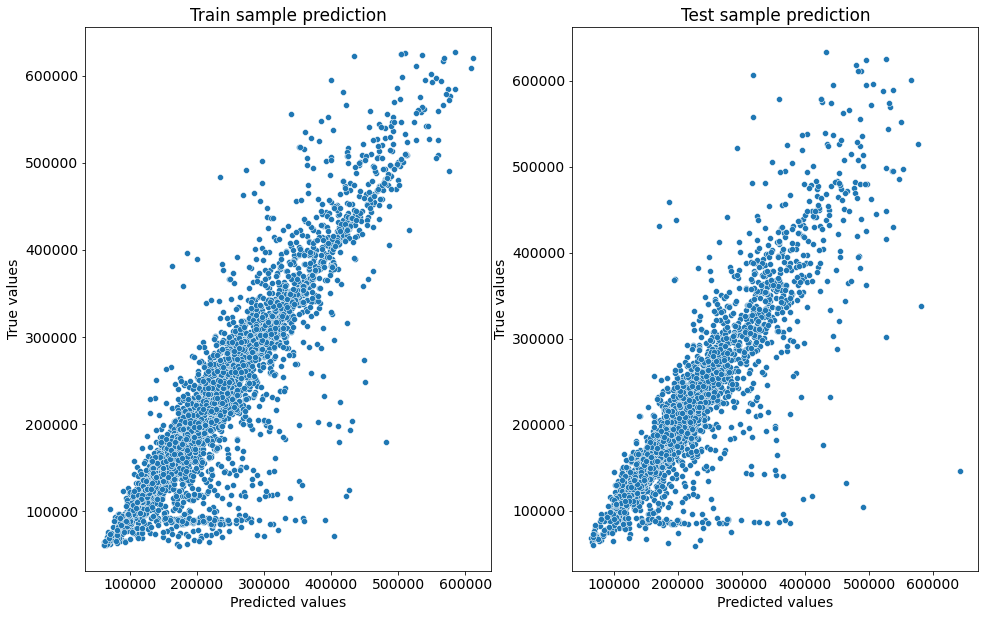

In [104]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [105]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.79467272, 0.73866578, 0.77993032])

In [106]:
cv_score.mean()

0.7710896064319733

**Оценка важности признаков**

In [107]:
importances = gb_model.feature_importances_

Text(0.5, 1.0, 'Feature importances')

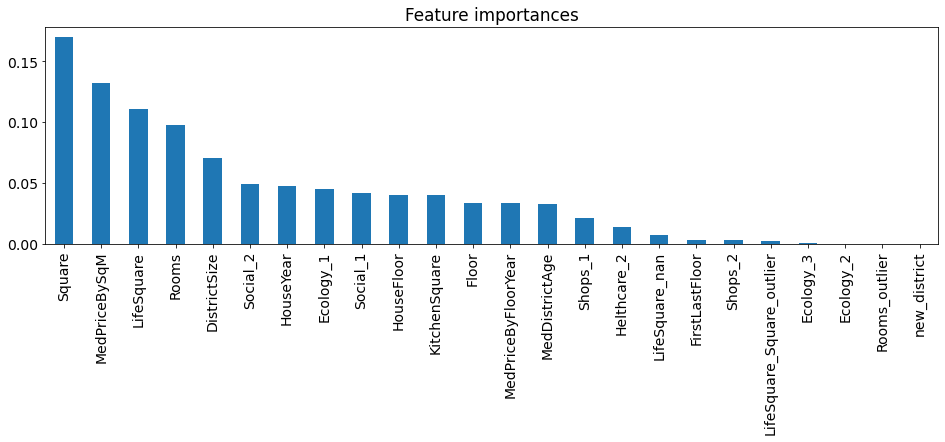

In [108]:
plt.figure(figsize = (16, 4))
pd.Series(importances, X_train.columns).sort_values(ascending=False).plot(kind="bar")
plt.title("Feature importances")

### 9. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [109]:
test_df.shape

(5000, 24)

In [110]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,LifeSquare_Square_outlier,LifeSquare_nan,MedPriceBySqM,FirstLastFloor,DistrictSize,new_district,MedDistrictAge,MedPriceByFloorYear
0,-1.101585,-1.019809,-1.154156,-1.216381,-0.504549,-0.742108,1970,-0.700705,1,1,...,1,0,0,0,4600.812988,0,76.0,0,1977.5,186518.438291
1,-1.101585,-0.719303,0.184192,1.521375,-0.130478,0.597771,2017,-0.399428,1,1,...,0,0,1,0,2831.963867,0,164.0,0,1977.0,178912.369081
2,0.132426,0.168244,0.299920,0.973824,2.113949,0.932741,1977,0.764732,1,1,...,1,0,0,1,2615.766113,1,580.0,0,1977.0,175622.388268
3,1.366436,-0.347491,-0.307690,-0.668830,-1.065656,-1.914503,1965,-0.885051,1,1,...,1,0,0,0,2164.099365,1,372.0,0,1977.0,179706.200399
4,-1.101585,-0.127330,0.181872,-0.668830,0.056557,0.597771,1977,1.584722,1,1,...,1,0,0,1,3298.512207,0,65.0,0,1992.0,193098.662333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.132426,-0.687291,-0.510954,-1.216381,-0.504549,-1.244563,1962,-0.420307,1,1,...,1,0,0,0,4177.195801,0,56.0,0,1967.0,186518.438291
4996,1.366436,2.009879,3.112817,1.521375,2.488020,2.272620,2018,-0.494777,1,1,...,1,0,1,0,4298.713867,0,26.0,0,2008.5,192358.950694
4997,-1.101585,-1.187432,-1.159356,-1.216381,-1.065656,-1.412048,1966,-0.679213,1,1,...,1,0,0,0,4296.658691,0,54.0,0,1966.0,179706.200399
4998,-1.101585,-0.925908,-1.046511,0.973824,0.056557,0.095316,1970,-0.258284,1,1,...,1,0,0,0,4661.066406,0,40.0,0,1973.0,193098.662333


In [111]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [112]:
predictions = gb_model.predict(test_df)
predictions

array([168442.49142201, 119245.80568426, 137805.85835703, ...,
       152100.60493973, 192032.82217335, 248128.12377735])

In [113]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,168442.491422
1,5925,119245.805684
2,960,137805.858357
3,3848,102338.409197
4,746,178591.806647


In [114]:
submit.to_csv('submission.csv', index=False)